In [15]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as st
from mjo_kelvin import *

### Open dataset for daily mean OLR

In [16]:
olr_nc = xr.open_dataset("olr.day.mean.nc")

In [17]:
lat = olr_nc['lat'] #all latitudes
lon = olr_nc['lon'] #all longitudes
time = olr_nc['time'] #all times
daily_olr = olr_nc['olr'] #all OLR

In [18]:
#get dates
years = daily_olr["time.year"]
months = daily_olr["time.month"]

#index of years included in WK99
yr_ind = np.where((years>=1979) & (years<=1996))[0]

end_year = np.where(years==1996)[0] #index for year 1996
mon_ind = np.where(months[end_year]==8)[0][-1] #get last day of august 1996

yr_ind = yr_ind[yr_ind<=end_year[mon_ind]]

### Filter OLR dataset depending on latitude and time

In [19]:
lat_in = np.where((lat <= 7.5) & (lat >= -7.5)) #only consider latitudes near the equator
daily_olr = daily_olr[yr_ind,lat_in[0],:] #consider OLR for WK99 timeframe
daily_olr = daily_olr.values

In [20]:
#latitudes for geopotential height and wind
min_lat = -5
max_lat = 5

In [21]:
#open filtered Kelvin waves
kelvin = np.load("kelvin_olr.npy")

kelvin_lats = lat[np.where((lat <= 15) & (lat >= -15))[0]]
kelvin_lat_ind = np.where((kelvin_lats <= 7.5) & (kelvin_lats >= -7.5))[0]

kelvin = kelvin[kelvin_lat_ind,:,:]

### Open 200 mb geopotential height dataset 

In [22]:
#geopotential height
hgt_nc = xr.open_dataset("dynamical data/hgt_200.nc")

#only consider geopotential height at 20-30N
hgt_lat_in = np.where((lat <= max_lat) & (lat >= min_lat))[0] 
hgt_200 = hgt_nc["hgt"].values[:kelvin.shape[1],hgt_lat_in]

### Open 200 mb u wind dataset 

In [23]:
#geopotential height
uwind_nc = xr.open_dataset("dynamical data/uwind_200.nc")

#only consider wind at 20-30N
uwind_lat_in = np.where((lat <= max_lat) & (lat >= min_lat))[0]
# uwind_lat_in = np.where((lat <= 5) & (lat >= -5))[0] 
uwind_200 = uwind_nc["uwnd"].values[:kelvin.shape[1],uwind_lat_in]

### Open 200 mb v wind dataset 

In [24]:
#geopotential height
vwind_nc = xr.open_dataset("dynamical data/vwind_200.nc")

#only consider wind at 20-30N
vwind_lat_in = np.where((lat <= max_lat) & (lat >= min_lat))[0]
# vwind_lat_in = np.where((lat <= 5) & (lat >= -5))[0] 
vwind_200 = vwind_nc["vwnd"].values[:kelvin.shape[1],vwind_lat_in]

### Get anomalies of dynamical data for composite

In [25]:
mean_hgt_anom = anoms_2d(hgt_200) #geopotential height
mean_uwind_anom = anoms_2d(uwind_200) #u wind
mean_vwind_anom = anoms_2d(vwind_200) #v wind
mean_olr_anom = anoms_2d(daily_olr) #OLR

## Time lagged composites of wind, geopotential height, and OLR anomalies with Kelvin wave

In [12]:
maxlag = 20
base_phase = 3
base_lon = 110

lag_olr,lag_hgt,lag_uwind,lag_vwind = composite(maxlag,base_phase,base_lon,lon,\
                                                mean_hgt_anom,mean_uwind_anom,mean_vwind_anom,mean_olr_anom)

57


## Time lagged composites of wind, geopotential height, and OLR anomalies without Kelvin wave

In [13]:
maxlag = 20
base_phase = 3
base_lon = 110

lag_olr_mjo,lag_hgt_mjo,lag_uwind_mjo,lag_vwind_mjo = composite_mjo(maxlag,base_phase,mean_hgt_anom,\
                                                    mean_uwind_anom,mean_vwind_anom,mean_olr_anom)

## Plotting wind with Kelvin wave

In [14]:
windplot_mask = np.zeros_like(lag_uwind)
windplot_mask[4::5,2::3] = 1 #plot every third wind vector

lag_uwind_mask = windplot_mask*lag_uwind
lag_vwind_mask = windplot_mask*lag_vwind

In [15]:
wind_mag = np.sqrt(lag_uwind_mask**2 + lag_vwind_mask**2)

uwind_mask = np.ma.masked_where(wind_mag < np.std(wind_mag), lag_uwind_mask)
vwind_mask = np.ma.masked_where(wind_mag < np.std(wind_mag), lag_vwind_mask)

## Plotting wind without Kelvin wave

In [16]:
windplot_mask = np.zeros_like(lag_uwind)
windplot_mask[4::5,2::3] = 1 #plot every third wind vector

lag_uwind_mask = windplot_mask*lag_uwind_mjo
lag_vwind_mask = windplot_mask*lag_vwind_mjo

In [17]:
wind_mag = np.sqrt(lag_uwind_mask**2 + lag_vwind_mask**2)

uwind_mask_mjo = np.ma.masked_where(wind_mag < np.std(wind_mag), lag_uwind_mask)
vwind_mask_mjo = np.ma.masked_where(wind_mag < np.std(wind_mag), lag_vwind_mask)

## Monte Carlo experiments to test significance of Kelvin wave signals

In [20]:
#get index of longitude
lon_in = np.where(lon==base_lon)[0][0]

In [21]:
mc_kelvin = np.mean(kelvin[:,:,lon_in],axis=0)

#remove mean from time series
kelvin_anom = (mc_kelvin-np.mean(mc_kelvin)).squeeze()

#get fft of anomalies
kelvin_fft = np.fft.fft(kelvin_anom)

#get power of fft
kelvin_power = (kelvin_fft*np.conj(kelvin_fft)).real

### Monte Carlo Method to get random spectrum corresponding to original power

In [22]:
def randdata(powervol_anom):
    half_power = powervol_anom[1:len(kelvin_fft)//2]
    
    #create array for random spectrum
    randspec = np.zeros_like(kelvin_fft)
    
    #(Re)^2 + (Im)^2 = power
    #get random multipliers
    rand_mult = np.random.rand(len(half_power))
    #get random squared real parts
    real_sqr = rand_mult*half_power
    #get random squared imaginary parts
    im_sqr = half_power-real_sqr
    
    #get square roots 
    real_rand = np.sqrt(real_sqr)
    im_rand = np.sqrt(im_sqr)

    #give random signs per real and imaginary part
    rand_sign_real = np.random.choice([-1,1],len(real_rand))
    rand_sign_im = np.random.choice([-1,1],len(im_rand))
    
    #get random spectrum composed of random real and imaginary parts
    randspec[1:len(half_power)+1] = (real_rand*rand_sign_real) + 1j*(im_rand*rand_sign_im)
    randspec[-len(half_power):] = np.flip(np.conj(randspec[1:len(half_power)+1]))
    
    #get inverse fourier transform
    randkelvin = fft.ifft(randspec).real
    
    return(randkelvin)

In [23]:
#generate randomized kelvin spectrum 1000 times
tests = 1000
rand_hgt = np.zeros((tests,kelvin.shape[2],2*maxlag+1))
# randkelvin = np.zeros((tests,len(kelvin_power)))
                      
for i in range(tests):
    randkelvin = randdata(kelvin_power) #generate random kelvin spectrum
    
    rand_hgt[i,:,:] = monte_carlo(randkelvin,maxlag,base_phase,mean_hgt_anom) #generate geohgt monte carlo

In [24]:
#get range of lower and upper 5% percentile
alpha = 0.025
sorted_hgt = np.sort(rand_hgt,axis=0)
lower_percent = sorted_hgt[int(len(sorted_hgt)*alpha),:,:] #lower range
upper_percent = sorted_hgt[-int(len(sorted_hgt)*alpha),:,:] #upper range

### Check if actual geopotential height is in 5% of null distribution

In [26]:
hgt_significance = np.zeros_like(lag_hgt)

for i in range(lower_percent.shape[0]):
    for j in range(lower_percent.shape[1]):
        if (lag_hgt[i,j] >= upper_percent[i,j]) or (lag_hgt[i,j] <= lower_percent[i,j]):
            hgt_significance[i,j] = 1

In [27]:
poscon_label = np.arange(1.5,11.5,1.5)
negcon_label = np.arange(-10,0,1.5)

## Plot composite of wind, geopotential height, and OLR without Kelvin wave

/tmp/ipykernel_26258/3440116233.py:7: UserWarning: No contour levels were found within the data range.
  plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),hgt_significance.T,[0],colors="xkcd:fuchsia",linewidths=2.8) #significant geo hgt


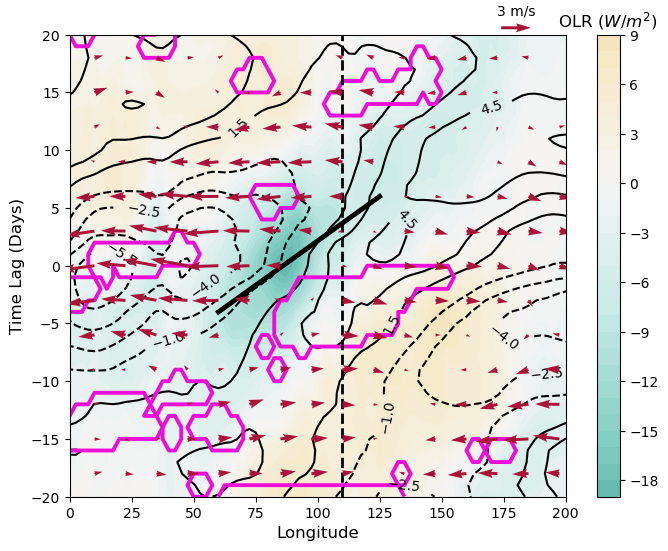

In [30]:
plt.figure(figsize=(8,6))

olr = plt.contourf(np.array(lon),np.arange(-maxlag,maxlag+1),lag_olr_mjo.T,30,cmap="BrBG_r",vmin=-40,vmax=40)
pos_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),lag_hgt_mjo.T,np.arange(1.5,11.5,1.5),colors="black") #positive anomalies
neg_con = plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),lag_hgt_mjo.T,np.arange(-10,0,1.5),colors="black") #negative anomalies

plt.contour(np.array(lon),np.arange(-maxlag,maxlag+1),hgt_significance.T,[0],colors="xkcd:fuchsia",linewidths=2.8) #significant geo hgt
wind = plt.quiver(np.array(lon),np.arange(-maxlag,maxlag+1),uwind_mask_mjo.T,vwind_mask_mjo.T,color="xkcd:rouge",zorder=10,scale=50,width=0.006)

plt.vlines(base_lon,-20,20,color="black",linestyle="--",linewidth=2) #base longitude

plt.plot((60,125),(-4,6),color='k',linewidth=3.5) #reference bar

plt.quiverkey(wind,0.9,1.015,3,label="3 m/s")

plt.clabel(pos_con,poscon_label[::2])
plt.clabel(neg_con,negcon_label)

cbr = plt.colorbar(olr)
cbr.ax.set_title('OLR ($W/m^2$)')
plt.xlim(0,200)
plt.xlabel("Longitude",fontsize=12)
plt.ylabel("Time Lag (Days)",fontsize=12)
# plt.title("OLR (shaded) and geopotential height (contours) at RMM phase "+str(base_phase),fontsize=14)
# plt.savefig("ATM561 Project/phase3_olr_hgt_110_nokelvin.png",dpi=300,bbox_inches="tight")

plt.show()